#### Initalizing Variables and Preprocessing Datasets

##### Packages

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_wavelets.Layers.DWT as wavelet
from keras.preprocessing.image import ImageDataGenerator

##### Constents

In [2]:
TRAIN_DATA_PATH = "Data/train"
VALID_DATA_PATH = "Data/valid"
TEST_DATA_PATH  = "Data/test"
BATCH_SIZE      = 16
TARGET_SIZE     = (227,227)
INPUT_SHAPE     = [227,227,3]

##### Data Preprocessing

###### Training Data Preprocessing

In [3]:
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator( rescale = 1.0/255.0,
                                                                        horizontal_flip = True,
                                                                        fill_mode = 'nearest',
                                                                        zoom_range=0.2,
                                                                        shear_range = 0.2,
                                                                        width_shift_range=0.2,
                                                                        height_shift_range=0.2,
                                                                        rotation_range=0.4)

train_data = train_data_generator.flow_from_directory(  TRAIN_DATA_PATH,
                                                        batch_size = BATCH_SIZE,
                                                        target_size = TARGET_SIZE,
                                                        class_mode = 'categorical')

Found 613 images belonging to 4 classes.


###### Validation Data Preprocessing

In [4]:
validation_data_generator = ImageDataGenerator(rescale = 1.0/255.0)

validation_data = validation_data_generator.flow_from_directory(     VALID_DATA_PATH,
                                                        target_size = TARGET_SIZE,
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = 'categorical')

Found 72 images belonging to 4 classes.


#### Initalizing Convolutional Neural Networks

##### Abstract Class

In [5]:
class CNNModel:
    def __init__(self, input_shape=0, model_type='', model_path=None):
        self.model_type = model_type
        self.history = None
        self.history_accuracy = []
        self.history_val_accuracy = []
        self.history_loss = []
        self.history_val_loss = []
        self.input_shape = input_shape
        self.model = tf.keras.models.Sequential()
        if(model_path==None):
            self.model_path = 'savedModel/CNNModel.ckpt'
        else:
            self.model_path = model_path
        self.model_checkpoint = tf.keras.callbacks.ModelCheckpoint(self.model_path,save_weights_only=True,verbose=1)

    def fit(self,train_data, validation_data, epochs):
        self.history = self.model.fit(x = train_data, validation_data = validation_data, epochs = epochs, callbacks=[self.model_checkpoint])
        self.history_accuracy.extend(self.history.history['accuracy'])
        self.history_val_accuracy.extend(self.history.history['val_accuracy'])
        self.history_loss.extend(self.history.history['loss'])
        self.history_val_loss.extend(self.history.history['val_loss'])

    def plotAccuracy(self):
        if(self.history != None):
            print(self.history.history.keys())
            plt.plot(self.history_accuracy)
            plt.plot(self.history_val_accuracy)
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train','test'], loc='upper left')
            plt.show()
        
    def plotLoss(self):
        if(self.history != None):
            plt.plot(self.history_loss)
            plt.plot(self.history_val_loss)
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()

    def compareAccuracy(models):
        modelList = []
        for model in models:
            if(model.history != None):
                plt.plot(model.history_accuracy)
                modelList.append(model.model_type)
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(modelList, loc='upper left')
        plt.show()

    def compareLoss(models):
        modelList = []
        for model in models:
            if(model.history != None):
                plt.plot(model.history_loss)
                modelList.append(model.model_type)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(modelList, loc='upper left')
        plt.show()

    def predict(self, path):
        classes_dir = ["Adenocarcinoma","Large cell carcinoma","Normal","Squamous cell carcinoma"]
        image = tf.keras.utils.load_img(path, target_size=TARGET_SIZE)
        normalizedImage = tf.keras.utils.img_to_array(image)/255
        imageArray = np.array([normalizedImage])
        predtionResult = np.argmax(self.model.predict(imageArray))
        print(classes_dir[predtionResult])

    def load(self,model_path=None):
        if(model_path==None):
            self.model.load_weights(self.model_path)
        else:
            self.model.load_weights(model_path)
            
    def summary(self):
        print(self.model.summary())

##### LeNet

In [6]:
class LeNet(CNNModel):
    def __init__(self,input_shape=0,model_path='savedModel/LeNet.ckpt'):

        super().__init__(input_shape=input_shape,model_type="LeNet",model_path=model_path)
        self.model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='tanh', strides=1, input_shape=input_shape, padding="same"))
        self.model.add(tf.keras.layers.AveragePooling2D(pool_size=2,strides=2, padding="valid"))
        
        self.model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, activation='tanh', padding="valid"))
        self.model.add(tf.keras.layers.AveragePooling2D(pool_size=2,strides=2, padding="valid"))
        
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(units=120, activation='tanh'))
        self.model.add(tf.keras.layers.Dense(units=84, activation='tanh'))
        self.model.add(tf.keras.layers.Dense(units=4, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics = ['accuracy'])

##### AlexNet

In [7]:
class AlexNet(CNNModel):
    def __init__(self,input_shape=0,model_path='savedModel/AlexNet.ckpt'):

        super().__init__(input_shape=input_shape,model_type="AlexNet",model_path=model_path)
        self.model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=11, activation='relu', strides=4, input_shape=input_shape))
        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, activation='relu'))
        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(units=4096, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(units=4096, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(units=4, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics = ['accuracy'])

##### Wavelet AlexNet

In [8]:
class WaveletAlexNet(CNNModel):
    def __init__(self,input_shape=0,model_path='savedModel/WaveletAlexNet.ckpt'):


        super().__init__(input_shape=input_shape,model_type="WaveletAlexNet",model_path=model_path)
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=5, activation='relu', strides=4, input_shape=input_shape))

        self.model.add(wavelet.DWT(name='bd2'))
        self.model.add(tf.keras.layers.Reshape((112, 112, 96)))

        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, activation='relu'))
        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Flatten(input_shape = (2,2,384)))
        self.model.add(tf.keras.layers.Dense(units=4096, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(units=4096, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(units=4, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics = ['accuracy'])

##### ResNet

In [9]:
class ResNet(CNNModel):
    def __init__(self,input_shape=0,model_path='savedModel/ResNet.h5'):
        if(input_shape==0):
            super().__init__(input_shape=input_shape,model_type="ResNet",model_path=model_path)
        else:
            super().__init__(input_shape=input_shape,model_type="ResNet")
            pretrained_model= tf.keras.applications.ResNet50(include_top=False,
            input_shape=INPUT_SHAPE,
            pooling='avg',classes=5,
            weights='imagenet')

        for layer in pretrained_model.layers:
            layer.trainable=True

        self.model.add(pretrained_model)
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(512, activation='relu'))
        self.model.add(tf.keras.layers.Dense(4, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics = ['accuracy'])
            

##### Modified ResNet

In [10]:
class HybridResNet(CNNModel):
    def __init__(self,input_shape=0,model_path='savedModel/HybridResNet.h5'):
        if(input_shape==0):
            super().__init__(input_shape=input_shape,model_type="HybridResNet",model_path=model_path)
        else:
            super().__init__(input_shape=input_shape,model_type="HybridResNet")
            pretrained_model= tf.keras.applications.ResNet50(include_top=False,
            input_shape=INPUT_SHAPE,
            pooling='max',classes=5,
            weights='imagenet')

        for layer in pretrained_model.layers:
            layer.trainable=True

        self.model.add(pretrained_model)
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(512, activation='relu'))
        self.model.add(tf.keras.layers.Dense(4, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics = ['accuracy'])

#### MAIN

##### Initialize Mode

In [11]:
alexNet = AlexNet(INPUT_SHAPE)

In [12]:
leNet = LeNet(INPUT_SHAPE)

In [13]:
waveletAlexNet = WaveletAlexNet(INPUT_SHAPE)

In [14]:
resNet = ResNet(INPUT_SHAPE)

##### Summary Mode

In [15]:
leNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 227, 227, 6)       456       
                                                                 
 average_pooling2d (AverageP  (None, 113, 113, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 16)      2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 54, 54, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [16]:
alexNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 384)         1

##### Training Modes

In [41]:
leNet.fit(train_data, validation_data, 32)

Epoch 1/32
39/39 [==============================] - ETA: 0s - loss: 1.5693 - accuracy: 0.2610
Epoch 1: saving model to savedModel\LeNet.ckpt
39/39 [==============================] - 13s 181ms/step - loss: 1.5693 - accuracy: 0.2610 - val_loss: 1.3790 - val_accuracy: 0.2917
Epoch 2/32
39/39 [==============================] - ETA: 0s - loss: 1.3993 - accuracy: 0.2953
Epoch 2: saving model to savedModel\LeNet.ckpt
39/39 [==============================] - 5s 133ms/step - loss: 1.3993 - accuracy: 0.2953 - val_loss: 1.5431 - val_accuracy: 0.3194
Epoch 3/32
39/39 [==============================] - ETA: 0s - loss: 1.4184 - accuracy: 0.2692
Epoch 3: saving model to savedModel\LeNet.ckpt
39/39 [==============================] - 5s 132ms/step - loss: 1.4184 - accuracy: 0.2692 - val_loss: 1.4782 - val_accuracy: 0.2083
Epoch 4/32
39/39 [==============================] - ETA: 0s - loss: 1.3915 - accuracy: 0.3083
Epoch 4: saving model to savedModel\LeNet.ckpt
39/39 [==============================] - 5

In [42]:
resNet.fit(train_data, validation_data, 32)

Epoch 1/32
39/39 [==============================] - ETA: 0s - loss: 0.9405 - accuracy: 0.5791
Epoch 1: saving model to savedModel\CNNModel.ckpt
39/39 [==============================] - 10s 171ms/step - loss: 0.9405 - accuracy: 0.5791 - val_loss: 1.4211 - val_accuracy: 0.2083
Epoch 2/32
39/39 [==============================] - ETA: 0s - loss: 0.5946 - accuracy: 0.7455
Epoch 2: saving model to savedModel\CNNModel.ckpt
39/39 [==============================] - 5s 139ms/step - loss: 0.5946 - accuracy: 0.7455 - val_loss: 1.5145 - val_accuracy: 0.2083
Epoch 3/32
39/39 [==============================] - ETA: 0s - loss: 0.4393 - accuracy: 0.8238
Epoch 3: saving model to savedModel\CNNModel.ckpt
39/39 [==============================] - 6s 142ms/step - loss: 0.4393 - accuracy: 0.8238 - val_loss: 1.5193 - val_accuracy: 0.2222
Epoch 4/32
39/39 [==============================] - ETA: 0s - loss: 0.3283 - accuracy: 0.8907
Epoch 4: saving model to savedModel\CNNModel.ckpt
39/39 [=======================

In [43]:
waveletAlexNet.fit(train_data, validation_data, 32)

Epoch 1/32
39/39 [==============================] - ETA: 0s - loss: 1.3694 - accuracy: 0.3067
Epoch 1: saving model to savedModel\WaveletAlexNet.ckpt
39/39 [==============================] - 9s 188ms/step - loss: 1.3694 - accuracy: 0.3067 - val_loss: 1.4001 - val_accuracy: 0.3194
Epoch 2/32
39/39 [==============================] - ETA: 0s - loss: 1.3394 - accuracy: 0.3148
Epoch 2: saving model to savedModel\WaveletAlexNet.ckpt
39/39 [==============================] - 6s 160ms/step - loss: 1.3394 - accuracy: 0.3148 - val_loss: 1.3828 - val_accuracy: 0.4583
Epoch 3/32
39/39 [==============================] - ETA: 0s - loss: 1.3255 - accuracy: 0.3181
Epoch 3: saving model to savedModel\WaveletAlexNet.ckpt
39/39 [==============================] - 7s 172ms/step - loss: 1.3255 - accuracy: 0.3181 - val_loss: 1.4149 - val_accuracy: 0.2222
Epoch 4/32
39/39 [==============================] - ETA: 0s - loss: 1.3095 - accuracy: 0.3768
Epoch 4: saving model to savedModel\WaveletAlexNet.ckpt
39/39 [

In [44]:
alexNet.fit(train_data, validation_data, 32)

Epoch 1/32
39/39 [==============================] - ETA: 0s - loss: 1.3754 - accuracy: 0.3034
Epoch 1: saving model to savedModel\AlexNet.ckpt
39/39 [==============================] - 7s 158ms/step - loss: 1.3754 - accuracy: 0.3034 - val_loss: 1.3842 - val_accuracy: 0.4722
Epoch 2/32
39/39 [==============================] - ETA: 0s - loss: 1.3512 - accuracy: 0.3132
Epoch 2: saving model to savedModel\AlexNet.ckpt
39/39 [==============================] - 5s 140ms/step - loss: 1.3512 - accuracy: 0.3132 - val_loss: 1.3897 - val_accuracy: 0.1944
Epoch 3/32
39/39 [==============================] - ETA: 0s - loss: 1.3343 - accuracy: 0.2920
Epoch 3: saving model to savedModel\AlexNet.ckpt
39/39 [==============================] - 5s 136ms/step - loss: 1.3343 - accuracy: 0.2920 - val_loss: 1.3854 - val_accuracy: 0.3889
Epoch 4/32
39/39 [==============================] - ETA: 0s - loss: 1.3268 - accuracy: 0.3344
Epoch 4: saving model to savedModel\AlexNet.ckpt
39/39 [============================

##### Comparing Accuracy


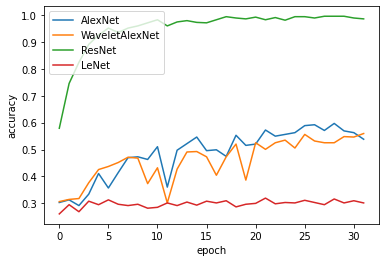

In [45]:
CNNModel.compareAccuracy([alexNet,waveletAlexNet,resNet,leNet])

##### Comparing Loss

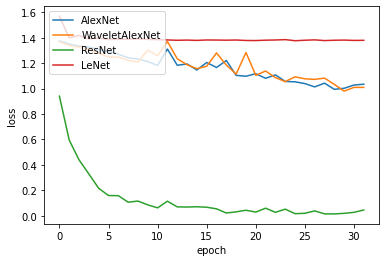

In [46]:
CNNModel.compareLoss([alexNet,waveletAlexNet,resNet,leNet])

##### Make Prediction

In [19]:
alexNet.predict("Data/test/adenocarcinoma/000114.png")

1/1 [==============================] - 0s 13ms/step
Squamous cell carcinoma


In [20]:
waveletAlexNet.predict("Data/test/adenocarcinoma/000114.png")

1/1 [==============================] - 0s 26ms/step
Squamous cell carcinoma


In [21]:
resNet.predict("Data/test/adenocarcinoma/000114.png")

1/1 [==============================] - 0s 15ms/step
Adenocarcinoma
